# The predictive power of XGBoost algorithem on stock prices

In [1]:
from stockpriceanna.pricegen import spgen #pip install stockpriceanna
import numpy as np
import pandas as pd
from xgboost import XGBRegressor #make sure it is upgraded to the 9.0 version or objective="reg:squarederror" will raise exception
from pylab import rcParams
from itertools import product
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
current_date=pd.Timestamp("2019-07-15") 

Some financial background

Here I focus on the predictive power of historical prices P. In practice, there are many potential attributes can be used for forecasting future price movements. My simple predictive model looks like this: 

$P_{t}$ = F([$P_{t-1}$,$P_{t-2}$.....$P_{t-k}$]) where $P_{t}$ is the observed stock price at time t. 

The function F is unknown and the XGBoost algorithm will find the estimated values of the function without any parametric assumptions. This advantage is particularly useful for predicting stock returns as the actual model that generates the stock prices can be overwhelmingly complicated. Prior studies in finance have suggested that stock prices follow random walk. If it is true, then the best predictor for future prices should be last known price so the predicted return in the random walk model is always zero. 

However, I believe that modeling the price levels using the XGBoost algorithm is unwise because the algorithm is not designed for interpolation beyond the training set. To go around, I will build a wrapper to transfer the raw price level data into returns for the XGB algorithm and then transfer the result back to a price forecast.

# A wrapper for data cleaning and feature engineering.  


In [69]:
class XGBreg():
    def __init__(self,base_score=0.5, booster='gbtree', colsample_bylevel=1.0,colsample_bytree=1.0, gamma=0, importance_type='gain',
                   learning_rate=0.1, max_delta_step=0, max_depth=3,min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                   nthread=None, random_state=0, reg_alpha=0,reg_lambda=1, scale_pos_weight=1, seed=100, silent=True,
                   subsample=1.0,use_log=True,use_level=True,lag_order=1,objective="reg:squarederror",name=None,y_att="price"):
        #model parameters that will not be tuned, be aware that objective = "reg:squarederror" is only available after xgboost 9.0, before that they use "reg:linear"
        self.other_setting={"base_score":base_score,"booster":booster,"importance_type":importance_type,"max_delta_step":max_delta_step,
                            "missing":missing,"n_jobs":n_jobs,"nthread":nthread,"random_state":random_state,"reg_alpha":reg_alpha,
                            "reg_lambda":reg_lambda,"scale_pos_weight":scale_pos_weight,"seed":seed,"objective":objective}
        
        #model parameters that will be tuned for performance
        self.set_param = {"n_estimators":n_estimators,"max_depth":max_depth,"learning_rate":learning_rate,
                          "min_child_weight":min_child_weight,"subsample":subsample,"gamma":gamma,"colsample_bytree":colsample_bytree,"colsample_bylevel":colsample_bylevel}
        self.reset(self.set_param,lag_order=lag_order)  
        if name is None:
            self.name="unnamed"
        else:
            self.name = name
        self.use_log=use_log
        self.use_level = use_level
        self.y_att=y_att
    
    def __set_param(self,**arg):
        for _ in arg.keys():
            if _ in self.set_param.keys():
                self.set_param[_] = arg[_]
        
    def reset(self,new_param={},lag_order=None):  
        """
        set the XGB parameters and prepare for a new training assignment
        """
        #check for invalid inputs
        if "n_estimators" in new_param.keys():
            n_estimators = new_param["n_estimators"]
            if not (isinstance(n_estimators,int) and n_estimators>0):
                raise ValueError ("invalid n_estimators setting")
            else:
                self.__set_param(n_estimators=n_estimators)
        
        if "max_depth" in new_param.keys():
            max_depth = new_param["max_depth"]
            if not (isinstance(max_depth,int) and max_depth>0):
                raise ValueError ("invalid max_depth setting")
            else:
                self.__set_param(max_depth=max_depth)
        
        if "learning_rate" in new_param.keys():
            learning_rate = new_param["learning_rate"]
            if not (isinstance(learning_rate,float) and learning_rate>0 and learning_rate<1):
                raise ValueError ("invalid learning_rate setting")
            else:
                self.__set_param(learning_rate=learning_rate)
        
        if "min_child_weight" in new_param.keys():
            min_child_weight = new_param["min_child_weight"]
            if not (isinstance(min_child_weight,int) and min_child_weight>0):
                raise ValueError ("invalid min_child_weight setting")
            else:
                self.__set_param(min_child_weight=min_child_weight)

        if "subsample" in new_param.keys():
            subsample = new_param["subsample"]
            if not (isinstance(subsample,(int,float)) and subsample>0 and subsample<=1):
                raise ValueError ("invalid subsample setting")
            else:
                self.__set_param(subsample=subsample)

        if "gamma" in new_param.keys():
            gamma = new_param["gamma"]
            if not (isinstance(gamma,(float,int)) and gamma>=0):
                raise ValueError ("invalid gamma setting")
            else:
                self.__set_param(gamma=gamma)

        if "colsample_bytree" in new_param.keys():
            colsample_bytree = new_param["colsample_bytree"]
            if not (isinstance(colsample_bytree,(float,int)) and colsample_bytree>0 and colsample_bytree<=1):
                raise ValueError ("invalid colsample_bytree setting")
            else:
                self.__set_param(colsample_bytree=colsample_bytree)                

        if "colsample_bylevel" in new_param.keys():
            colsample_bylevel = new_param["colsample_bylevel"]
            if not (isinstance(colsample_bylevel,(float,int)) and colsample_bylevel>0 and colsample_bylevel<=1):
                raise ValueError ("invalid colsample_bylevel setting")    
            else:
                self.__set_param(colsample_bylevel=colsample_bylevel) 
                
        if lag_order is not None:
            self.lag_order = lag_order
        self.model=XGBRegressor(**{**self.set_param,**self.other_setting})
        #https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
        self.data = None #place holder

    def data_cleaner(self,data,next_date=None):
        """
        take a raw price series or a data set as input, return the responding time-indexed x data set, which contains all the lagged variables. 
        The time stamp for the one-step forward trade date is not unknown from the raw data set and thus it is either provided in the next_date argument or it will be estimated

        """
        y_att = self.y_att
        if isinstance(data,pd.Series):
            price_series = data
        else:
            if y_att not in data.columns:
                raise ValueError ("the y variable %s is not found in the dataset"%(y_att))
            price_series = data[y_att]
        if next_date is None:
            est_gap = data.index[-1]-data.index[-2] #the date of one-step prediction is being estimated here
            new_index=data.index[1:].append(pd.DatetimeIndex([data.index[-1]+est_gap])) 
        else:
            new_index=data.index[1:].append(pd.DatetimeIndex([next_date])) #the raw index is converged here to a data table. each observation of "y-price" is matched with its predictors
        new_x = pd.DataFrame(index=new_index)
        if self.use_log:
            new_x["P_lag1"] = np.log(price_series).values #log-price is being stored here if log-return is chosen 
            new_x["R_lag1"] = (new_x["P_lag1"] - new_x["P_lag1"].shift(1))
        else:
            new_x["P_lag1"] = price_series.values
            new_x["R_lag1"] = (new_x["P_lag1"] - new_x["P_lag1"].shift(1))/new_x["P_lag1"].shift(1)
        
        if isinstance(data,pd.DataFrame) and data.shape[1]>1: #for additional predictors 
            for att in set(data.columns)-set([y_att]):
                new_x["%s_lag1"%(att)] = data[att].values
            
        if self.lag_order>1:
            for i in range(2,self.lag_order+1):
                new_x["P_lag%s"%(i)] = new_x["P_lag1"].shift(i-1).values
                new_x["R_lag%s"%(i)] = new_x["R_lag1"].shift(i-1).values
                if isinstance(data,pd.DataFrame) and data.shape[1]>1:
                    for att in set(data.columns)-set([y_att]):
                        new_x["%s_lag%s"%(att,i)] = new_x["%s_lag1"%(att)].shift(i-1).values
        return new_x.dropna()
        
    def train(self,data,eval_size=None,early_stopping_rounds=None,decay_weight=None): 
        """
        weight_decay allows time decreasing weight assigned to pass observations
        eval_size and early_stopping_rounds setting allows early stopping
        """
        if not isinstance(data.index,pd.DatetimeIndex):
            raise ValueError ("need a time index pd.Series or pd.DataFrame as data input")
        else:
            self.data = data #keeping the training set here
        self.train_x = self.data_cleaner(data).iloc[:-1] #the last obs is not used in training because the one-step forward future price is not known
        if not self.use_level:
            train_x = self.train_x.drop(["P_lag%s"%(i) for i in range(1,self.lag_order+1)],axis=1)
        else:
            train_x = self.train_x
        if isinstance(data,pd.Series):
            y_data = data.astype(float)
        if isinstance(data,pd.DataFrame):
            y_data = data[self.y_att].astype(float)
        if self.use_log:
            self.train_y = (np.log(y_data)-np.log(y_data.shift(1))).reindex(self.train_x.index) #some observation in x are dropped due to the use of lag values
        else:
            self.train_y = (y_data/y_data.shift(1) -1).reindex(self.train_x.index)
        if decay_weight is not None:
            if decay_weight!=1:
                weight = [decay_weight**(self.train_y.size-i) for i in range(self.train_y.size)]
            else:
                weight = None
        else:
            weight = None
        if eval_size is None:
            self.model.fit(X=train_x, y=self.train_y,eval_metric="rmse",sample_weight=weight) 
        else:
            self.model.fit(X=train_x.iloc[:-eval_size], y=self.train_y[:-eval_size],
                           eval_set=[(self.train_x.iloc[-eval_size:],self.train_y[-eval_size:])],eval_metric="rmse",verbose=False,sample_weight=weight)
    
    def predict(self,prediction_step=1,new_x=None):
        """
        prediction_step=0 return the est values of the training_set
        prediction_step=1 return the one-step prediction outsite the training_set
        when new_x is provided, this method return the est values of the date in the new_x plus a one-step prediction.
        new_x must include price level data
        """
        if new_x is not None:    
            if not isinstance(new_x.index,pd.DatetimeIndex):
                raise ValueError ("require pd.Series type with pd.DatetimeIndex")
            if new_x.index[0]>self.data.index[-1]:
                temp_data = self.data.iloc[-(self.lag_order+1):].append(new_x) #plus 1 because return value need one more past observations
                new_x = self.data_cleaner(temp_data)
            else:
                raise ValueError ("new observations must be dated after the old ones")      
        else:
            if prediction_step==0:
                new_x = self.train_x
            elif prediction_step==1:
                temp_data = self.data.iloc[-(self.lag_order+1):]  #+1 becuase the return value need one more lag
                new_x = self.data_cleaner(temp_data).iloc[-1:]
            else:
                raise ValueError ("invalid prediction_step") 
        lag_y = new_x["P_lag1"]
        if not self.use_level:
            new_x = new_x.drop(["P_lag%s"%(i) for i in range(1,self.lag_order+1)],axis=1)
        est = self.model.predict(new_x)
        est = pd.Series(est,index=new_x.index)  #the index is in line with the realization of y
        if self.use_log:
            return np.exp(lag_y+est) 
        else:
            return lag_y *(1+est)

# some simple tests

linear trend test:
In one-step prediction, XGBoost predicts 20.11204044694593, the correct answer is 20.110000000000003
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 0.00013
converging wave test:
In one-step prediction, XGBoost predicts 0.4565372702155707, the correct answer is 0.4562066531295291
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 0.00039

expanding wave test:
In one-step prediction, XGBoost predicts 8.060022687666148, the correct answer is 8.055151457804083
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 0.00057

trending wave test:
In one-step prediction, XGBoost predicts 10.922929206426137, the correct answer is 10.921980356450282
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 5e-05


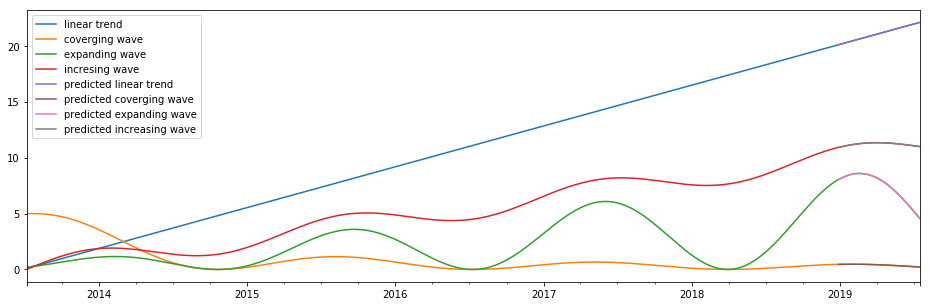

In [92]:
def get_MAPE (est_price,realized_price,rd=5):
    """
    return the MAPE score and the benchmark score
    """
    return round((abs(est_price - realized_price)/realized_price).mean(),rd)

train_size=2000
test_size=200

test_func0 = lambda x: 0.1+0.01*x #linear trend
train_set0 = pd.Series([test_func0(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set0 = pd.Series([test_func0(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x0 = XGBreg(name="linear trend")
x0.train(train_set0)
pred0 = x0.predict(prediction_step=1)[0]
preds0 = x0.predict(new_x=test_set0.dropna())
print ("linear trend test:")
print ("In one-step prediction, XGBoost predicts %s, the correct answer is %s" %(pred0,test_func0(train_size+1)))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds0,test_set0)))

test_func1 = lambda x: (5/(1+0.01*x))*(1+np.sin(x/100)) #coverging wave
train_set1 = pd.Series([test_func1(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set1 = pd.Series([test_func1(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x1 = XGBreg(name="converging wave")
x1.train(train_set1)
pred1 = x1.predict(prediction_step=1)[0]
preds1 = x1.predict(new_x=test_set1.dropna())
print ("converging wave test:")
print ("In one-step prediction, XGBoost predicts %s, the correct answer is %s" %(pred1,test_func1(train_size+1)))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds1,test_set1)))

test_func2 = lambda x: (1+0.01*x)*(1+np.sin(x/100))/5 #expanding wave
train_set2 = pd.Series([test_func2(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set2 = pd.Series([test_func2(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x2 = XGBreg(name="expanding wave")
x2.train(train_set2)
pred2 = x2.predict(prediction_step=1)[0]
preds2 = x2.predict(new_x=test_set2.dropna())
print ("\nexpanding wave test:")
print ("In one-step prediction, XGBoost predicts %s, the correct answer is %s" %(pred2,test_func2(train_size+1)))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds2,test_set2)))

test_func3 = lambda x: 0.005*x+np.sin(x/100) #incresing wave
train_set3 = pd.Series([test_func3(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set3 = pd.Series([test_func3(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x3 = XGBreg(name="expanding wave")
x3.train(train_set3)
pred3 = x3.predict(prediction_step=1)[0]
preds3 = x3.predict(new_x=test_set3.dropna())
print ("\ntrending wave test:")
print ("In one-step prediction, XGBoost predicts %s, the correct answer is %s" %(pred3,test_func3(train_size+1),))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds3,test_set3)))

train_set0.append(test_set0).plot()
train_set1.append(test_set1).plot()
train_set2.append(test_set2).plot()
train_set3.append(test_set3).plot()
preds0.plot()
preds1.plot()
preds2.plot()
p0=preds3.plot()
p0.legend(['linear trend','coverging wave','expanding wave','incresing wave', 'predicted linear trend','predicted coverging wave', 'predicted expanding wave', 'predicted increasing wave'])

The estimates are close to the correct answers. The algorithm appears to work well on finding recurrent patterns. However, in the financial market stock prices are marked by noises (maybe caused by liquidity or uninformed trades). Let's see how the algorithm performs when noises are present. To stimulate stock prices under noise, I will need the spgen class from a package I wrote for the job. For detail description of the spgen class, please check https://github.com/edwincca/stockpriceanna/blob/master/README.md.

Some more background

A geometric random walk is generated by: 

$P_{t}$ = $P_{t-1}$*exp($R_{t}$)

where $R_{t}$ follows a normal distribution and is not related to any past information. This means that log$P_{t}$ = log$P_{t-1}$  + $R_{t}$  and $R_{t}$  represents new information arriving the market between the time period. Thus, according to this random walk model, the best predictor of future price level at any time t is the current price level. spgen class allows users to quickly generate stock prices exhibited random walk or other predictable behaviors. The price generating model I am using in simulation can be generlized as log$P_{t}$  = log$P_{t-1}$  + $R_{t}$ + $A_{t}$  + $N_{t}$ , where $A_{t}$  is some non-random walk(predictable) factor that have lasting effect on stock prices and $N_{t}$ is a noise factor that has only one-period effect on the stock prices (e.g. liquidity). 


# Simulating random walk and other predictable behaviours in stock prices

summary statistics of simulated stock returns
                                      mean       std       min       max  \
random walk                       0.000271  0.010003 -0.031534  0.039586   
random walk + fixed trend         0.001271  0.010003 -0.030534  0.040586   
random walk + reversals           0.000271  0.017222 -0.059473  0.061740   
random walk + momentum            0.000746  0.013516 -0.055392  0.046596   
random walk + periodic moves      0.000271  0.015943 -0.069558  0.066034   
random walk + price level effect  0.000271  0.009847 -0.047851  0.033824   

                                  autocorr1  autocorr2  autocorr3  
random walk                       -0.008633   0.010708  -0.019427  
random walk + fixed trend         -0.008633   0.010708  -0.019427  
random walk + reversals           -0.329085   0.012050  -0.024390  
random walk + momentum             0.651991   0.390923   0.174237  
random walk + periodic moves      -0.003302   0.013098  -0.020276  
random walk +

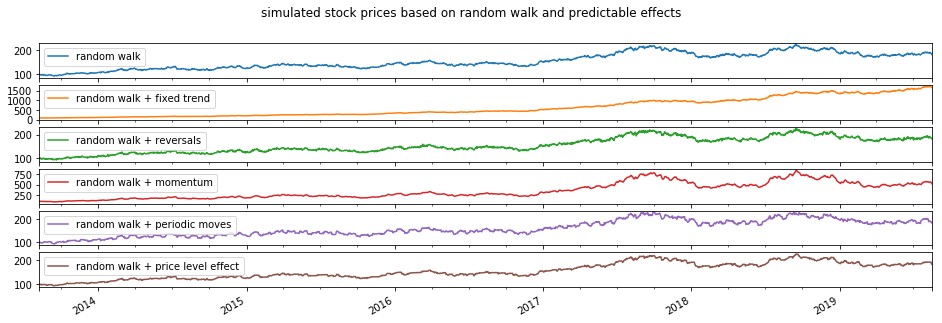

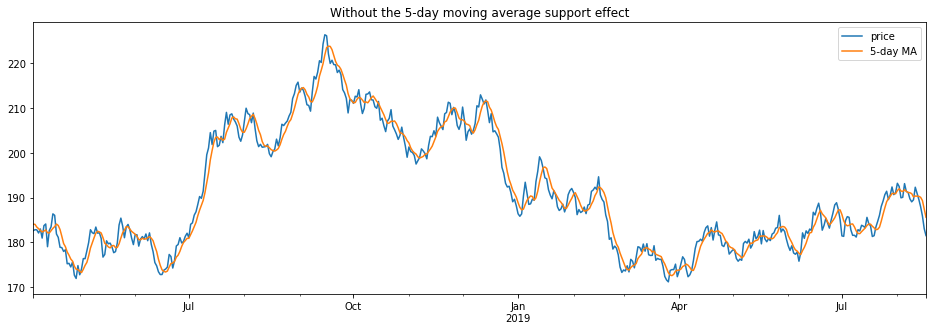

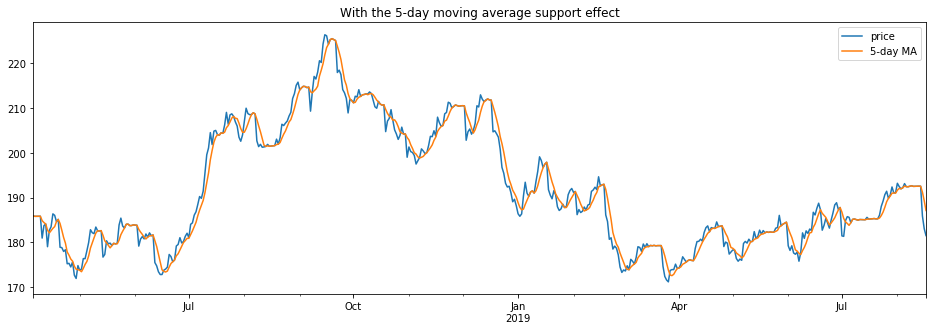

In [94]:
seed_factor=1
seed_noise=2
std = 0.01 #period-to-period std in returns.
trend_size=0.001
noise_std = 0.01
mom_size=0.7
pm_size=1.05

name_list = ['random walk', 'random walk + fixed trend','random walk + reversals', 'random walk + momentum','random walk + periodic moves','random walk + price level effect']
spgen_list=[spgen(size=train_size+test_size) for i in range(len(name_list))]
sp_list=[]

#a geometric random walk
spgen_list[0].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")   
spgen_list[0].gen_price(method="m")
sp_list.append(spgen_list[0].show_price())

#a geometric random walk with a fixed trend
spgen_list[1].gen_ln(mean=0,std=std,seed=seed_factor,name="factor") 
spgen_list[1].gen_trend(rate=trend_size,name="trend")
spgen_list[1].gen_price(method="m")
sp_list.append(spgen_list[1].show_price())

#a geometric random walk with noise (reversals)
spgen_list[2].gen_ln(mean=0,std=std,seed=seed_factor,name="factor") 
spgen_list[2].gen_ln(mean=0,std=noise_std,seed=seed_noise,name="noise",add_type="noise")
spgen_list[2].gen_price(method="m")
sp_list.append(spgen_list[2].show_price())

#a geometric random walk with a positive autocorrelation in returns (momentum effect)
spgen_list[3].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")
spgen_list[3].gen_ac(base="factor",rate=mom_size,lag=3,name="lag3_ac")
spgen_list[3].gen_price(method="m")
sp_list.append(spgen_list[3].show_price())

#a geometric random walk with periodic moves
spgen_list[4].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")  
def pfunc (p,size=pm_size):
    if p ==0:
        return 1/size
    elif p == 11:  #seeing top and bottom in every 12-period window
        return  size
    else:
        return 1
spgen_list[4].gen_periodic(name="p12",func=pfunc,period=30)
spgen_list[4].gen_price(method="m")
sp_list.append(spgen_list[4].show_price())

#a geometric random walk with price support effect
spgen_list[5].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")  
#a filter function for setting up the price effect - using the 5-day moving average as a support level
def MA5_filter(price,*args,**kargs):
    if price.size>5:
        temp_ma_lag = price.iloc[-6:-1].mean()
        temp_ma = price.iloc[-5:].mean()
        if price.iat[-2]>=temp_ma_lag and price.iat[-1]<temp_ma and price.iat[-1]>temp_ma*0.98:
            return price.iloc[-5:-1].mean()
        else:
            return price.iat[-1]
    else:
        return price.iat[-1]
spgen_list[5].gen_price(method="m",price_filter=MA5_filter)
sp_list.append(spgen_list[5].show_price())


#plot the price level data in 5 separate subplot
rcParams['figure.figsize'] = 16,5
pd.DataFrame(sp_list,index=name_list).T.plot(subplots=True,title="simulated stock prices based on random walk and predictable effects")
pd.DataFrame([sp_list[0],sp_list[0].rolling(5).mean()],index=["price","5-day MA"]).T.iloc[-500:].plot(title="Without the 5-day moving average support effect")
pd.DataFrame([sp_list[5],sp_list[5].rolling(5).mean()],index=["price","5-day MA"]).T.iloc[-500:].plot(title="With the 5-day moving average support effect")

#prepare the summary statistics for returns
spr_list=[np.log(sp_list[i])-np.log(sp_list[i].shift(1)) for i in range(len(name_list))]
report0=pd.DataFrame([spr_list[i].describe() for i in range(len(name_list))])[["mean","std","min","max"]]
report0.index=name_list
report0["autocorr1"] = [spr_list[i].autocorr(1) for i in range(len(name_list))]
report0["autocorr2"] = [spr_list[i].autocorr(2) for i in range(len(name_list))]
report0["autocorr3"] = [spr_list[i].autocorr(3) for i in range(len(name_list))]       
       
print ("summary statistics of simulated stock returns")
print (report0)


# How the XGBoost performs when noise is present?

In [97]:
score_saver0 = []
use_level=True
spgen_preds0=[]
for i in range(len(name_list)):
    xgb_temp=XGBreg(name=name_list[i],use_log=True,use_level=use_level)
    xgb_temp.train(sp_list[i].iloc[:train_size])
    temp_est=xgb_temp.predict(new_x=sp_list[i].iloc[train_size:train_size+test_size])
    spgen_preds0.append(temp_est)
    cv_score = get_MAPE(temp_est,sp_list[i].iloc[-test_size:])
    score_saver0.append(cv_score)
    ben_score = get_MAPE(sp_list[i].iloc[-(test_size+1):].shift(1).dropna(),sp_list[i].iloc[train_size:train_size+test_size])
    print ("%s: XGBoost MAPE score: %s, the benchmark score: %s" % 
           (name_list[i],
            cv_score,
            ben_score))
    

random walk: XGBoost MAPE score: 0.00769, the benchmark score: 0.00764
random walk + fixed trend: XGBoost MAPE score: 0.00801, the benchmark score: 0.00765
random walk + reversals: XGBoost MAPE score: 0.01276, the benchmark score: 0.01344
random walk + momentum: XGBoost MAPE score: 0.00804, the benchmark score: 0.01063
random walk + periodic moves: XGBoost MAPE score: 0.01003, the benchmark score: 0.00997
random walk + price level effect: XGBoost MAPE score: 0.0064, the benchmark score: 0.00591


The XGB algorithm outperforms the benchmark when there are autocorrelation in returns, but in other cases, it does not appear to recognize the predictable patterns. One interesting observation is that the algorithm cannot even recognize a simple trend. My interpretation is that the trend setting results in lots of new highs which require the predictive algorithm to interpolate. If result is much improved when the "use_level" setting is turn off (try rerun the previous block with this setting).  

In the previous test, all predictions are based on the same model that is trained by some fixed training set, the model will have to make more distanced forecast for prices that are far away from the training window and any dynamic changes in between will certainly add to the prediction error. While the underlying price discovery process is complicated, it is reasonable to conjecture that recent information has stronger predictive power on future price moves. In other words, the estimates are likely to be more reliable when the training period is close. To test this theory, I will try a rolling-window validation approach in which each price forecast is a one-step forward predication from the preceding training window. This approach stands closer to the financial world where new observations come bit by bit as time goes. 

# time validatoin approach

In [98]:
def tv(data,train_size,xgb,slient=False,return_MAPE=True,eval_size=None,early_stopping_rounds=None,y_att="price",decay_weight=None):
    """  
    Short for time-validation,this method perform validation by using the rolling-window approach.
    test_size = data size - train size. each prediction in the test set is based on the immediately preceeding training window
    eval_size an earily_stopping_rounds will passed to the API for early stopping
    on-line learning compacity can be added to this method but may not be useful for a tree-based learning algorithem.
    """
    if not slient:
        print ("performing rolling-window validation on %s" %(xgb.name))
        rt = None #place holder
        last_report=None
    if isinstance(data,pd.Series):
        realized_price = data.copy()
    else:
        realized_price = data[xgb.y_att].copy()
    realized_price.name = "realized_price"
    result = pd.DataFrame(realized_price).iloc[train_size:]
    result["est_price"] = np.NaN
    start_time = pd.datetime.today()
    for i in range(train_size,data.shape[0]):
        if not slient:
            temp_t = pd.datetime.today()
        train_data = data.iloc[i-train_size:i]
        xgb.train(train_data,eval_size=eval_size,early_stopping_rounds=early_stopping_rounds,decay_weight=decay_weight)
        result.at[data.index[i],"est_price"] = xgb.predict(prediction_step=1)[0]
        if not slient:
            lt = pd.datetime.today() - temp_t
            new_rt = ((data.shape[0] - i -1 )*lt).seconds
            if rt is None:
                print ("estimated time to finish %s seconds" %(new_rt))
                rt = max([new_rt,1])
            else:
                if last_report is None:
                    last_report = int(100*(new_rt/rt))
                else:
                    if last_report > (int(100*(new_rt/rt))+20):
                        print ("progress percentage %s%%" % (int(100*(1-new_rt/rt))))
                        last_report = int(100*(new_rt/rt))
    if not slient:
        print ("completed in %s seconds" % ((pd.datetime.today()-start_time).seconds))
    result = result.dropna()
    if return_MAPE:
        MAPE = get_MAPE(result["est_price"],result["realized_price"])
        benchmark_MAPE = get_MAPE(realized_price.shift(1),result["realized_price"])
        return [result,MAPE,benchmark_MAPE]
    else:
        return result

# trying the time validation on simulated stock prices

In [99]:
booster = "gbtree"
n_jobs=4  #adjust this setting for your computer's CPU. This block can take a few minutes to finish.
slient=False
use_level=True
XGB_list1=[XGBreg(name=name,booster=booster,use_log=True,use_level=use_level,n_jobs=n_jobs) for name in name_list]
vs_list1=[tv(data=sp_list[i],train_size=train_size,slient=slient,xgb=XGB_list1[i]) for i in range(len(name_list))]
tv_score = [vs_list1[i][1] for i in range(len(name_list))]
tv_benscore = [vs_list1[i][2] for i in range(len(name_list))]
report1 = pd.DataFrame([tv_score,score_saver0,tv_benscore],columns=report0.index,index=["tv_est","cv_est","benchmark_est"]).T
print (report1)

performing rolling-window validation on random walk
estimated time to finish 53 seconds
progress percentage 22%
progress percentage 45%
progress percentage 66%
progress percentage 88%
completed in 47 seconds
performing rolling-window validation on random walk + fixed trend
estimated time to finish 43 seconds
progress percentage 16%
progress percentage 44%
progress percentage 65%
progress percentage 86%
completed in 46 seconds
performing rolling-window validation on random walk + reversals
estimated time to finish 47 seconds
progress percentage 23%
progress percentage 44%
progress percentage 68%
progress percentage 89%
completed in 47 seconds
performing rolling-window validation on random walk + momentum
estimated time to finish 48 seconds
progress percentage 16%
progress percentage 56%
progress percentage 77%
progress percentage 100%
completed in 47 seconds
performing rolling-window validation on random walk + periodic moves
estimated time to finish 48 seconds
progress percentage 16%
p

The time-validation approach is expected to do better at least in the last two cases where the distance between the training and prediction windows matters, but the results do not support such an expectation. In particular, the algorithm does not appear to recognize the predictive role of past price levels. My guess is that the default setting of the algorithm may not fit for the presence of noise. To adjust the parameters, I will use the training set to find the best parameter setting that achieves the highest score and then use the setting to perform time validation over the test set.   

# Parameter Tuning Proecedure 

In [100]:
def tuning(data,xgb,parameter_range,cv_rate=0.1,slient=False):
    """
    This method finds the best parameter that has the highest t-validation score
    The search domain is provided through parameter_ranage - a dict type argument containing the possible values for each parameter
    cv_rate determines the size of test set in each t-validation run. 
    
    """
    train_size = int(data.shape[0]*(1-cv_rate))
    best_param = xgb.set_param.copy()
    if not slient:
        print ("In %s, calculating the basic score using the default parameter set %s" %(xgb.name,best_param))
    xgb.reset()
    best_score= tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
    if not slient:
        print ("completed, basic score: %s" %(best_score))
        print ("In %s, finding the best lag order from %s" %(xgb.name,parameter_range["lag_order"]))
    best_lo = xgb.lag_order #lag_order need to be added back to the param set here because it was not designed as a part of the XGB's parameter set.
    for lo in parameter_range["lag_order"]:#find best lag
        xgb.reset(lag_order=lo)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score: #the smaller the better
            best_score  = temp_score
            best_lo = lo
    if not slient:
        print ("done - best lag order %s,current best score %s "%(best_lo,best_score))
        print ("In %s, finding the best n_estimators and max_depth_range from %s" %(xgb.name,[parameter_range["n_estimators"],parameter_range["max_depth"]]))
    for n_est,md in product(parameter_range["n_estimators"],parameter_range["max_depth"]):
        xgb.reset(lag_order=best_lo,new_param={"n_estimators":n_est,"max_depth":md})
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score
            best_param["n_estimators"] = n_est
            best_param["max_depth"] = md
    if not slient:
        print ("done, best n_estimators and max_depth: %s,current best score %s" %([best_param["n_estimators"],best_param["max_depth"]],best_score))
        print ("In %s, finding the best learning_rate and min_child_weight from %s" %(xgb.name,[parameter_range["learning_rate"],parameter_range["min_child_weight"]]))
    
    for lr,mcw in product(parameter_range["learning_rate"],parameter_range["min_child_weight"]):
        temp_param = best_param.copy()
        temp_param["learning_rate"]=lr
        temp_param["min_child_weight"]=mcw
        xgb.reset(lag_order=best_lo,new_param=temp_param)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score
            best_param["learning_rate"] = lr
            best_param["min_child_weight"] = mcw
    if not slient:
        print ("done, best learning_rate and min_child_weight: %s,current best score %s" %([best_param["learning_rate"],best_param["min_child_weight"]],best_score))
        print ("In %s, finding the best subsample and gamma from %s" %(xgb.name,[parameter_range["subsample"],parameter_range["gamma"]]))
    for sub,gamma in product(parameter_range["subsample"],parameter_range["gamma"]):
        temp_param = best_param.copy()
        temp_param["subsample"]=sub
        temp_param["gamma"]=gamma
        xgb.reset(lag_order=best_lo,new_param=temp_param)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score 
            best_param["subsample"] = sub
            best_param["gamma"] = gamma
    if not slient:
        print ("done, best subsample and gamma: %s,current best score %s" %([best_param["subsample"],best_param["gamma"]],best_score))                      
        print ("In %s, finding the best colsample_bytree and colsample_bylevel from %s" %(xgb.name,[parameter_range["colsample_bytree"],parameter_range["colsample_bylevel"]]))
    for cbt,cbl in product(parameter_range["colsample_bytree"],parameter_range["colsample_bylevel"]):
        temp_param = best_param.copy()
        temp_param["colsample_bytree"]=cbt
        temp_param["colsample_bylevel"]=cbl        
        xgb.reset(lag_order=best_lo,new_param=temp_param)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score   
            best_param["colsample_bytree"] = cbt
            best_param["colsample_bylevel"] = cbl
    if not slient:
        print ("done, best colsample_bytree and colsample_bylevel: %s,current best score %s" %([best_param["colsample_bytree"],best_param["colsample_bylevel"]],best_score))
    best_param["lag_order"] = best_lo
    return [best_param,best_score]

def run_test(data,xgb,train_size,cv_rate,parameter_range,reopti_size=None,detail_report=False):
    reopti_counter = 1 #use to count the round after each tuning
    overall_result = pd.DataFrame(columns=["est_price","realized_price"],index=data.index[train_size:])
    if isinstance(data,pd.Series):
        overall_result["realized_price"] = data
        realized_price = data
    else:
        overall_result["realized_price"] = data[xgb.y_att]
        realized_price = data[xgb.y_att]
    for i in range(train_size,data.shape[0]): #i is the position of the data.index
        if reopti_counter == reopti_size:
            opti_data = data.iloc[i-train_size-reopti_size+1:i-reopti_size+1]
            test_data = data.iloc[i-reopti_size+1:i+1]
            print ("In %s, performing parameter tuning on training period [%s,%s] for the best XGBoost parameters(cv_rate %s):" %(xgb.name,opti_data.index[0].strftime("%Y-%m-%d"),opti_data.index[-1].strftime("%Y-%m-%d"),cv_rate))
            best_param = tuning(data = opti_data,xgb=xgb,parameter_range=parameter_range,cv_rate=cv_rate,slient= (not detail_report))
            print ("done,best parameter set %s" %(best_param))
            print ("use the best parameters to perform rolling-window cv on the test set [%s,%s]"%(test_data.index[0].strftime("%Y-%m-%d"),test_data.index[-1].strftime("%Y-%m-%d")))
            bl = best_param[0].pop("lag_order")
            xgb.reset(lag_order=bl,new_param = best_param[0])
            temp_result = tv(data=data.iloc[i-train_size-reopti_size+1:i+1],train_size=train_size,xgb=xgb,slient=(not detail_report))
            print ("interval report: tuning score: %s, test score: %s, benchmark score (test period): %s" % (best_param[1],temp_result[1],temp_result[2]))
            overall_result["est_price"].update(temp_result[0]["est_price"])
            reopti_counter=1
        else:
            reopti_counter+=1
        if i == data.shape[0]-2 and reopti_counter != reopti_size:
            reopti_size = reopti_counter
    MAPE = get_MAPE(overall_result["est_price"],overall_result["realized_price"])
    benchmark_MAPE = get_MAPE(realized_price.shift(1),overall_result["realized_price"])
    print ("overall score %s (vs benchmark score %s)" %(MAPE,benchmark_MAPE))
    return [overall_result,MAPE,benchmark_MAPE]

In [101]:
n_jobs=4 #adjust this setting for your computer's CPU. This block can take more than an hour.
cv_rate=0.04 #cv_rate is the portion of sample that are used in validation in the training set for finding the best parameter set - high number require more computing time
use_level=True
booster = "gbtree"
parameter_range = {"lag_order":[2,10,30],"n_estimators":[200,400],"learning_rate":[0.15,0.2],
                   "subsample":[0.1,0.3,0.6],"gamma":[0.1,1],"max_depth":[1,3,5],"min_child_weight":[3,5,15],"colsample_bytree":[0.3,0.6,0.9],"colsample_bylevel":[0.3,0.6,0.9]}

XGB_list2=[XGBreg(name=name,booster=booster,n_jobs=n_jobs,use_level=use_level) for name in name_list]
rt_result = [run_test(data=sp_list[i],xgb=XGB_list2[i],train_size=train_size,cv_rate=cv_rate,parameter_range=parameter_range) for 
             i in range(len(name_list))]

In random walk, performing parameter tuning on training period [2013-08-09,2019-01-29] for the best XGBoost parameters(cv_rate 0.04):
done,best parameter set [{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'min_child_weight': 5, 'subsample': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 10}, 0.00864]
use the best parameters to perform rolling-window cv on the test set [2019-01-30,2019-08-17]
interval report: tuning score: 0.00864, test score: 0.00766, benchmark score (test period): 0.00764
overall score 0.00766 (vs benchmark score 0.00764)
In random walk + fixed trend, performing parameter tuning on training period [2013-08-09,2019-01-29] for the best XGBoost parameters(cv_rate 0.04):
done,best parameter set [{'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 1.0, 'gamma': 0, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'lag_order': 30}, 0.0083]
use the best parameters to perform rollin

In [102]:
print ("Summary Report: MAPE score for modeling simulated stock prices")
report2 = pd.DataFrame([[rt_result[i][1] for i in range(len(name_list))],vs_xgb1,score_saver0,vs_ben1],columns=report0.index,index=["tuned_tv","tv","cv","benchmark"]).T
print (report2)

Summary Report: MAPE score for modeling simulated stock prices
                                  tuned_tv       tv       cv  benchmark
random walk                        0.00766  0.00767  0.00769    0.00764
random walk + fixed trend          0.00829  0.00821  0.00801    0.00765
random walk + reversals            0.01282  0.01257  0.01276    0.01344
random walk + momentum             0.00805  0.00811  0.00804    0.01063
random walk + periodic moves       0.00841  0.00996  0.01003    0.00997
random walk + price level effect   0.00590  0.00640  0.00640    0.00591


The performance appears to improve significant for the last two sets of data after parameter tuning however the optimization sequence requires lots of computing time. The results suggest that the XGB algorithem can more or less recognize all the predictable patterns except for the fixed trend. The XGBoost package in Python supports parallel computing. Users should adjust the setting of n_jobs for the best performance.   

# Predicting Real Stock Market Price

Finally, I will try the algorithm on some real stock price data. I pick the SP500 market index simply because it is popular. The algorithem should be ready for any market data. Many prior studies have shown that it is very difficult to beat the random-walk predictor in modeling SP500 index. The following code will try to find the best parameter set based on the training set and then use the optimized model to conduct time-validation on the test set. 

In [103]:
from pandas_datareader import data
train_size=2000
test_size=150
data_sp500= data.DataReader('^GSPC', 'yahoo', "1980-01-01", "2019-01-01")
SP500_index_early = data_sp500.iloc[:train_size+test_size]["Adj Close"]
SP500_index_recent =  data_sp500.iloc[-(train_size+test_size):]["Adj Close"]
SP500_data_early = pd.DataFrame(SP500_index_early).rename(columns={"Adj Close":"price"})
SP500_data_recent = pd.DataFrame(SP500_index_recent).rename(columns={"Adj Close":"price"})
#SP500_data["HL"] = SP500_HL

"""
data_SSE= data.DataReader('000001.SS', 'yahoo',  "1999-01-01", "2019-01-01")
data_SSE = data_SSE.iloc[-(train_size+test_size):]
SSE_index= data_SSE["Adj Close"].iloc[-(train_size+test_size):]
SSE_HL = np.log(data_SSE["High"]) - np.log(data_SSE["Low"])
#SSE_ABV = data_SSE["Volume"] - data_SSE["Volume"].rolling(60).mean()
SSE_size = SSE_index.size
SSE_data = pd.DataFrame(SSE_index).rename(columns={"Adj Close":"price"})
SSE_data["HL"] = SSE_HL
"""
SP500_r_early = SP500_index_early/SP500_index_early.shift(1)-1
SP500_r_recent = SP500_index_recent/SP500_index_recent.shift(1)-1
#SSE_r = SSE_index/SSE_index.shift(1)-1
report3 =pd.DataFrame([SP500_r_early,SP500_r_recent],index=["SP500_return_early","SP500_return_recent"]).T
report3 = report3.describe().T[["mean","std","min","max"]]
report3["autocorr1"] = [SP500_r_early.autocorr(1),SP500_r_recent.autocorr(1)]
report3["autocorr2"] = [SP500_r_early.autocorr(2),SP500_r_recent.autocorr(2)]
report3["autocorr3"] = [SP500_r_early.autocorr(3),SP500_r_recent.autocorr(3)]   
print ("Summary Statistics of Stock Index Daily Returns between 1999-01-01 and 2019-01-01\n")
print (report3)

Summary Statistics of Stock Index Daily Returns between 1999-01-01 and 2019-01-01

                         mean       std       min       max  autocorr1  \
SP500_return_early   0.000503  0.011186 -0.204669  0.090994   0.063363   
SP500_return_recent  0.000419  0.009238 -0.066634  0.049594  -0.039214   

                     autocorr2  autocorr3  
SP500_return_early   -0.047251  -0.039666  
SP500_return_recent   0.019736  -0.047897  


The statistics are interesting. Market returns are on average positive. Market volatility is lower for more recent data. The return autocorrelations are small and not stable. Everything appears to suggest that the market index follows a random walk + small fix trend(XGB is not good at this). 

Now let's use the auto-tuning procedure to perform time validation on the real market data. Since I don't know the population model that generates the market data and based on the statistics the predictive role (if it is significant) of historical prices changes over time, it seems I should recalibrate the XGB parameters from period to period. The run_test method has the reopti_size setting that allows user to reoptimize the parameters after a fixed size of estimates have been made by the model.

In [109]:
reopti_size = 50 #this means that the program will run the parameter tuning precedure again after making 50 forecasts,decreasing this number increases computing time but may reduce error. 
n_jobs = 4 
cv_rate = test_size/train_size
parameter_range = {"lag_order":[2,10,30],"n_estimators":[200,400],"learning_rate":[0.15,0.2],
                   "subsample":[0.3,0.6,0.9],"gamma":[0.1,1],"max_depth":[1,3,5],"min_child_weight":[3,5,15],"colsample_bytree":[0.3,0.6,0.9],"colsample_bylevel":[0.3,0.6,0.9]}
XGB_SP500_early = XGBreg(name="SP500_early",n_jobs=4,use_log=True,use_level=True)
XGB_SP500_recent = XGBreg(name="SP500_recent",n_jobs=4,use_log=True,use_level=True)
rt_SP500_early =run_test(data=SP500_index_early,train_size=train_size,cv_rate=cv_rate,xgb=XGB_SP500_early,parameter_range=parameter_range,detail_report=False,reopti_size=reopti_size)
rt_SP500_recent =run_test(data=SP500_index_recent,train_size=train_size,cv_rate=cv_rate,xgb=XGB_SP500_recent,parameter_range=parameter_range,detail_report=False,reopti_size=reopti_size)

In SP500_early, performing parameter tuning on training period [1980-01-02,1987-11-27] for the best XGBoost parameters(cv_rate 0.075):
done,best parameter set [{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.15, 'min_child_weight': 15, 'subsample': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 1}, 0.01236]
use the best parameters to perform rolling-window cv on the test set [1987-11-30,1988-02-09]
interval report: tuning score: 0.01236, test score: 0.01397, benchmark score (test period): 0.01402
In SP500_early, performing parameter tuning on training period [1980-03-13,1988-02-09] for the best XGBoost parameters(cv_rate 0.075):
done,best parameter set [{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.15, 'min_child_weight': 15, 'subsample': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 1}, 0.01487]
use the best parameters to perform rolling-window cv on the test set [1988-02-10,1988-04-21]
interv

# Does the Fear Index have predictive power on market return?

As a quick demonstration, I will try adding some potential predictors to my simple predictive model for the SP500 index. The old school of finance frequently mentions that uncertainty is priced, which means that uncertainty as a factor may determine future asset returns.The VIX index is my first choice for the "fear gauge". Another instrument for measuring the level of uncertainty is trading volume because divergency of opinion makes people trade. 

In [113]:
#download the VIX index data, and prepare the index and return data, here I use log price and log return
train_size=2000
test_size=150
data_vix = data.DataReader('^VIX', 'yahoo', "2005-01-01", "2019-01-01") 
SP500_index = data_sp500["Adj Close"]
SP500_lr = np.log(SP500_index) - np.log(SP500_index).shift(1)
SP500_index.name = "SP500_index"
SP500_lr.name = "SP500_lr"
vix_index = data_vix["Adj Close"]
vix_lr = np.log(vix_index) - np.log(vix_index.shift(1))
vix_index.name = "VIX_index"
vix_lr.name = "VIX_lr"
vol = data_sp500["Volume"]/data_sp500["Volume"].rolling(60).mean() #normalized the volume value by its 60 moving average
vol.name = "VOL"
#join all the modeling data series into a dataframe
sp500_vix= pd.concat([SP500_index,SP500_lr,vix_index,vix_lr,vol],axis=1,join ="inner")
#use the most recent data part for the task. train_size and test_size was set previously
sp500_vix = sp500_vix.iloc[-(train_size+test_size):]
#prepare the statistics
report4 = sp500_vix[["SP500_lr","VIX_lr","VIX_index","VOL"]].describe().T[["mean","std","min","max"]]
print ("Summary Statistics of Stock Index Daily Returns and VIX returns between %s and %s\n"%(sp500_vix.index[0].strftime("%Y-%m-%d"),sp500_vix.index[-1].strftime("%Y-%m-%d")))
print (report4)
sp500_vix["logVIX"] = np.log(sp500_vix["VIX_index"])
sp500_vix = sp500_vix.drop(["SP500_lr","VIX_index"],axis=1) 


Summary Statistics of Stock Index Daily Returns and VIX returns between 2010-06-18 and 2019-01-02

                mean       std       min        max
SP500_lr    0.000377  0.009252 -0.068958   0.048403
VIX_lr     -0.000035  0.076935 -0.314140   0.768245
VIX_index  16.711321  5.632928  9.140000  48.000000
VOL         0.997236  0.182044  0.277873   1.997754


In [115]:
reopti_size = 50 #this means that the program will run the parameter tuning precedure again after making 50 forecasts,decreasing this number increases computing time but may reduce error. 
n_jobs = 4 
cv_rate = test_size/train_size
parameter_range = {"lag_order":[2,10,30],"n_estimators":[200,400],"learning_rate":[0.15,0.2],
                   "subsample":[0.3,0.6,0.9],"gamma":[0.1,1],"max_depth":[1,3,5],"min_child_weight":[3,5,15],"colsample_bytree":[0.3,0.6,0.9],"colsample_bylevel":[0.3,0.6,0.9]}
XGB_SV = XGBreg(name="SP500_VIX",n_jobs=4,y_att="SP500_index",use_log=True,use_level=True)
rt_SP500_VIX =run_test(data=sp500_vix,train_size=train_size,cv_rate=0.1,xgb=XGB_SV,parameter_range=parameter_range,reopti_size=reopti_size)


In SP500_VIX, performing parameter tuning on training period [2010-06-18,2018-05-29] for the best XGBoost parameters(cv_rate 0.1):
done,best parameter set [{'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 2}, 0.00544]
use the best parameters to perform rolling-window cv on the test set [2018-05-30,2018-08-08]
interval report: tuning score: 0.00544, test score: 0.00439, benchmark score (test period): 0.0045
In SP500_VIX, performing parameter tuning on training period [2010-08-30,2018-08-08] for the best XGBoost parameters(cv_rate 0.1):
done,best parameter set [{'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 2}, 0.00588]
use the best parameters to perform rolling-window cv on the test set [2018-08-09,2018-10-18]
interval report: tu

In [129]:
print ("Summary of performance scores for modeling the SP500 index")
report3 = pd.DataFrame([[rt_SP500_early[1],rt_SP500_early[2]],[rt_SP500_recent[1],rt_SP500_recent[2]],[rt_SP500_VIX[1],rt_SP500_VIX[2]]],index=["SP500_early","SP500_recent","SP500_recent_multi-predictor"],columns=["TV scores","Benchmark"])
print (report3)

Summary of performance scores for modeling the SP500 index
                              TV scores  Benchmark
SP500_early                     0.00981    0.00985
SP500_recent                    0.00704    0.00702
SP500_recent_multi-predictor    0.00703    0.00702


The XGB algorithm is good at performing feature selection. From the output log I can see that all of the added features do not play any significant roles in the final decision tree. The program chooses a gamma setting of 0.1 to prevent unfruitful branching based on the added features. From the point of view of finance school, the result suggests that in daily frequency risk as a pricing factor is priced efficiently in the U.S market.